<a href="https://colab.research.google.com/github/Dyakonov/Colab/blob/main/dj_CLUSTERexperiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Эксперименты с кластеризацией эмбедингов

Попытка сделать общий пайплайн

* UMAP https://umap-learn.readthedocs.io/
* DBSACAN https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html



* скачиваем данные (CLINC - 151 класс)
* берём какую-нибудь модель - из неё представления
* кластеризация в исходном пространстве представлений
* кластеризация в UMAP-пространстве
* перебор параметров


### выводы

* В исходном пространстве всё совсем плохо...
* Для CLINC+UMAP В UMAP лучше использовать cos-метрику - и меньше зависимость от параметров
* В DBSCAN оптимальный eps разный для разных метрик (эвклидова и косинусная)
* SVD/PCA хуже UMAP
* Стандартизация чуть ухудшает качество

In [ ]:
# установка необходимых библиотек
!pip install transformers
!pip install datasets
!pip install umap-learn
!pip install -U sentence-transformers
#!pip install fasttsne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 32.6 MB/s 
     |████████████████████████████████| 120 kB 57.2 MB/s 
     |████████████████████████████████| 6.6 MB 55.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 9.2 MB/s 
     |████████████████████████████████| 212 kB 64.6 MB/s 
     |████████████████████████████████| 115 kB 49.1 MB/s 
     |████████████████████████████████| 127 kB 50.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.2 MB/s 
     |████████████████████████████████| 1.1 MB 61.5 MB/s 
  Created wheel for umap-

## Определение функций и импотр библиотек

In [ ]:
# импорт библиотек

from time import time
from tqdm.autonotebook import tqdm
import numpy as np
import torch

from sentence_transformers import SentenceTransformer
from datasets import load_dataset

import umap

from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics  import fowlkes_mallows_score
from sklearn.metrics  import adjusted_mutual_info_score
from sklearn.metrics  import adjusted_rand_score
from sklearn.metrics.cluster import v_measure_score

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
# import warnings
# warnings.filterwarnings("ignore")
# pd.set_option('display.max_columns', None)
import matplotlib as mpl
plt.rc('font', size=14)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def make_coding_model(model='sbert', mode='paraphrase-MiniLM-L6-v2'):
  """
  кодирующая модель - для получения представлений
  """
  if model == 'sbert':
    print (f'модель: {model}, модификация: {mode}')
    model = SentenceTransformer(mode)
    return model.encode
  print ('Неизвестная модель')
  return NaN


def make_dataset(coding_model, name='clinc', mode='train'):
  """
  датасет для экспериментов
  """
  print (f'датасет {name}, часть {mode}')
  if name == 'clinc':
    data = load_dataset("clinc_oos", "plus")
    m = data["train"].num_rows # число объектов в датасете
    print (f'число объектов = {m}')

    n = len(coding_model('example'))
    print (f'число признаков = {n}')

    X = np.zeros([m, n])
    y = np.zeros(m)

    texts = data[mode]['text']
    labels = data[mode]['intent']

    for j in tqdm(range(m)):
      X[j, :] =  coding_model(texts[j]) #model.encode(texts[j])
      y[j] = labels[j]
    return X, y, data

  print("Неизвестный запрос")
  return NaN, NaN, NaN

In [ ]:
coding_model = make_coding_model(model='sbert', mode='sentence-t5-base') # 'paraphrase-MiniLM-L6-v2'
X, y, data = make_dataset(coding_model, name='clinc', mode='train')

модель: sbert, модификация: sentence-t5-base


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/115 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/74.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/198 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/219M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/461 [00:00<?, ?B/s]

датасет clinc, часть train


Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

Dataset clinc_oos downloaded and prepared to /root/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

число объектов = 15250
число признаков = 768


  0%|          | 0/15250 [00:00<?, ?it/s]

In [ ]:
np.save('/content/drive/My Drive/clusterdata/X_save', X)
np.save('/content/drive/My Drive/clusterdata/y_save', y)

## k-means с нужным числом кластеров

Перебираем параметры UMAP

In [ ]:
# Эксперименты - пробуем разные параметры UMAP

# параметры
parameters_n_neighbors = [4, 8, 16, 32, 64] #
parameters_min_dist = [0, 0.001, 0.01, 0.1, 0.5, 1.0] #
parameters_n_components = [2, 32, 64, 128]

# инициализация
V = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
H = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
C = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
NC =  np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)), dtype=int)
FM = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
MI = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
RS = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
T = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))

l = len(np.unique(y))
print (f'число кластеров = {l}')

# перебор
for i, n_neighbors in enumerate(parameters_n_neighbors): # tqdm
  for j, min_dist in enumerate(parameters_min_dist):
    for k, n_components in enumerate(parameters_n_components):

      t0 = time()
      reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric='euclidean') # cosine
      embedding = reducer.fit_transform(X)
      clustering_emb = KMeans(n_clusters=l).fit(embedding)
      a = clustering_emb.labels_

      V[i, j, k] = v_measure_score(y, a)
      H[i, j, k] =homogeneity_score(y, a)
      C[i, j, k] = completeness_score(y, a)
      NC[i, j, k] = len(np.unique(a))
      FM[i, j, k] = fowlkes_mallows_score(y, a)
      MI[i, j, k] = adjusted_mutual_info_score(y, a)
      RS[i, j, k] = adjusted_rand_score(y, a)
      T[i, j, k] = time() - t0

      print (f"i={i}, j={j}, k={k} n_neighbors={n_neighbors}, min_dist={min_dist}, n_components={n_components}, V={np.round(V[i, j, k], 4)}, H={np.round(H[i, j, k], 4)}, C={np.round(C[i, j, k], 4)}, NC={np.round(NC[i, j, k], 4)}, FM={np.round(FM[i, j, k], 4)}, MI={np.round(MI[i, j, k], 4)}, RS={np.round(RS[i, j, k], 4)}, T={np.round(T[i, j, k], 4)}")

число кластеров = 151
i=0, j=0, k=0 n_neighbors=4, min_dist=0, n_components=2, V=0.7286, H=0.721, C=0.7364, NC=151, FM=0.3702, MI=0.6795, RS=0.3638, T=15.6796
i=0, j=0, k=1 n_neighbors=4, min_dist=0, n_components=32, V=0.7687, H=0.7447, C=0.7944, NC=151, FM=0.3993, MI=0.7301, RS=0.3761, T=24.0184
i=0, j=0, k=2 n_neighbors=4, min_dist=0, n_components=64, V=0.7963, H=0.7675, C=0.8273, NC=151, FM=0.4585, MI=0.7641, RS=0.4345, T=34.4921
i=0, j=0, k=3 n_neighbors=4, min_dist=0, n_components=128, V=0.7964, H=0.7646, C=0.831, NC=151, FM=0.4433, MI=0.7643, RS=0.4137, T=56.2192
i=0, j=1, k=0 n_neighbors=4, min_dist=0.001, n_components=2, V=0.7299, H=0.7228, C=0.7371, NC=151, FM=0.3744, MI=0.6807, RS=0.3683, T=15.0336
i=0, j=1, k=1 n_neighbors=4, min_dist=0.001, n_components=32, V=0.7673, H=0.7456, C=0.7904, NC=151, FM=0.3994, MI=0.7278, RS=0.3788, T=23.1076
i=0, j=1, k=2 n_neighbors=4, min_dist=0.001, n_components=64, V=0.8016, H=0.7721, C=0.8335, NC=151, FM=0.4645, MI=0.7706, RS=0.44, T=33.604

(0.4, 0.9)

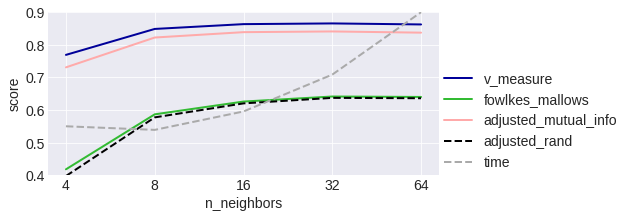

In [ ]:
import matplotlib.pyplot as plt

x_axis = parameters_n_neighbors
axis = (1, 2)
x_axis_name = 'n_neighbors'

plt.figure(figsize=(7, 3))
plt.plot(x_axis, np.mean(V, axis=axis), lw=2, c='#000099', label='v_measure') #  V = #np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
plt.plot(x_axis, np.mean(FM, axis=axis), lw=2, c='#33BB33', label='fowlkes_mallows')
plt.plot(x_axis, np.mean(MI, axis=axis), lw=2, c='#FFAAAA', label='adjusted_mutual_info')
plt.plot(x_axis, np.mean(RS, axis=axis), '--', lw=2, c='#000000', label='adjusted_rand')
t = np.mean(T, axis=axis)
t = 0.9 * t / np.max(t)
plt.plot(x_axis, t, '--', lw=2, c='#AAAAAA', label='time')
plt.xscale('log')
plt.xticks(x_axis, x_axis)
plt.grid()
plt.xlabel(x_axis_name)
plt.ylabel('score')
plt.legend(loc=(1,0))
plt.ylim([0.4, 0.9])

(0.4, 0.9)

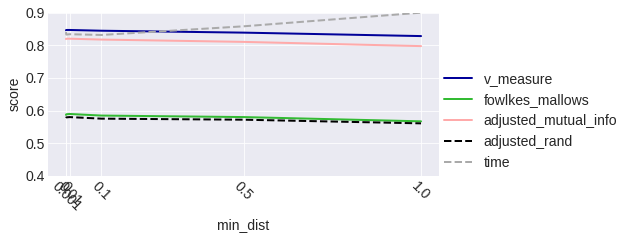

In [ ]:
import matplotlib.pyplot as plt

x_axis = parameters_min_dist
axis = (0, 2)
x_axis_name = 'min_dist'

plt.figure(figsize=(7, 3))
plt.plot(x_axis, np.mean(V, axis=axis), lw=2, c='#000099', label='v_measure') #  V = #np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
plt.plot(x_axis, np.mean(FM, axis=axis), lw=2, c='#33BB33', label='fowlkes_mallows')
plt.plot(x_axis, np.mean(MI, axis=axis), lw=2, c='#FFAAAA', label='adjusted_mutual_info')
plt.plot(x_axis, np.mean(RS, axis=axis), '--', lw=2, c='#000000', label='adjusted_rand')
t = np.mean(T, axis=axis)
t = 0.9 * t / np.max(t)
plt.plot(x_axis, t, '--', lw=2, c='#AAAAAA', label='time')
# plt.xscale('log')
plt.xticks(x_axis, x_axis, rotation=-45)
plt.grid()
plt.xlabel(x_axis_name)
plt.ylabel('score')
plt.legend(loc=(1,0))
plt.ylim([0.4, 0.9])

(0.5, 0.86)

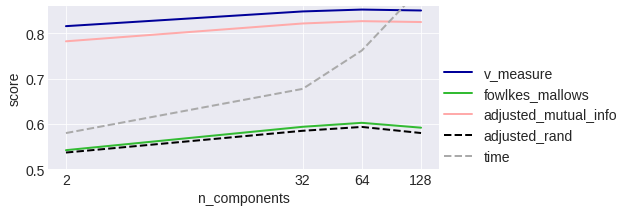

In [ ]:
x_axis = parameters_n_components
axis = (0, 1)
x_axis_name = 'n_components'

plt.figure(figsize=(7, 3))
plt.plot(x_axis, np.mean(V, axis=axis), lw=2, c='#000099', label='v_measure') #  V = #np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
plt.plot(x_axis, np.mean(FM, axis=axis), lw=2, c='#33BB33', label='fowlkes_mallows')
plt.plot(x_axis, np.mean(MI, axis=axis), lw=2, c='#FFAAAA', label='adjusted_mutual_info')
plt.plot(x_axis, np.mean(RS, axis=axis), '--', lw=2, c='#000000', label='adjusted_rand')
t = np.mean(T, axis=axis)
t = 0.5 * t / np.max(t) + 0.4
plt.plot(x_axis, t, '--', lw=2, c='#AAAAAA', label='time')
plt.xscale('log')
plt.xticks(x_axis, x_axis)
plt.grid()
plt.xlabel(x_axis_name)
plt.ylabel('score')
plt.legend(loc=(1,0))
plt.ylim([0.5, 0.86])

In [ ]:
ind = np.unravel_index(np.argmax(V, axis=None), V.shape)
ind, parameters_n_neighbors[ind[0]], parameters_min_dist[ind[1]], parameters_n_components[ind[2]]
# оптимальные параметры 32, 0.001, 64
# i=3, j=1, k=2 n_neighbors=32, min_dist=0.001, n_components=64, V=0.875, H=0.8672, C=0.8829, NC=151, FM=0.6578, MI=0.8522, RS=0.6532, T=44.6297

((3, 1, 2), 32, 0.001, 64)

## Сохранение и загрузка результатов вычислений

In [ ]:
# !mkdir -p clusterdata
# np.save('/content/drive/My Drive/clusterdata/climc_umap01_V.npy', V)


savedata = {'V': V,
            'H': H,
            'C': C,
            'NC': NC,
            'FM': FM,
            'MI': MI,
            'RS': RS,
            'T': T}

np.save('/content/drive/My Drive/clusterdata/climc_umap01_save.npy', savedata)

In [ ]:
# вот так загружается!!!!
data2=np.load('/content/drive/My Drive/clusterdata/climc_umap01_save.npy', allow_pickle=True)
data2[()]['V']

array([[[0.72863071, 0.76873025, 0.79629067, 0.79638837],
        [0.72987159, 0.76734025, 0.801615  , 0.79002547],
        [0.73097589, 0.77712427, 0.80140194, 0.79446269],
        [0.72554144, 0.76614847, 0.79850034, 0.79295122],
        [0.68920995, 0.79258574, 0.80452253, 0.7852513 ],
        [0.62395922, 0.80135545, 0.80499667, 0.79333755]],

       [[0.8372219 , 0.85809069, 0.85585057, 0.85362292],
        [0.84342845, 0.8603936 , 0.85844925, 0.85526746],
        [0.83241773, 0.85748313, 0.85982725, 0.85512323],
        [0.8295484 , 0.85945273, 0.86057443, 0.85372101],
        [0.81316551, 0.85835479, 0.85632409, 0.8567364 ],
        [0.7680138 , 0.86199939, 0.86174292, 0.86293491]],

       [[0.86799137, 0.86719994, 0.86483712, 0.86700827],
        [0.86396809, 0.86809383, 0.86798746, 0.86996162],
        [0.86550419, 0.86877078, 0.8665178 , 0.86779902],
        [0.86601892, 0.86849647, 0.86932292, 0.86507118],
        [0.84350689, 0.86782984, 0.86398858, 0.8714634 ],
        [0

## Аналогично, но с cos-мерой сходства

In [ ]:
# Эксперименты - пробуем разные параметры UMAP

# параметры
parameters_n_neighbors = [8, 16, 32, 64] #
parameters_min_dist = [0, 0.001, 0.01, 0.1, 0.5] #
parameters_n_components = [32, 64, 128]

# инициализация
V = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
H = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
C = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
NC =  np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)), dtype=int)
FM = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
MI = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
RS = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
T = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))

l = len(np.unique(y))
print (f'число кластеров = {l}')

# перебор
for i, n_neighbors in enumerate(parameters_n_neighbors): # tqdm
  for j, min_dist in enumerate(parameters_min_dist):
    for k, n_components in enumerate(parameters_n_components):

      t0 = time()
      reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric='cosine') # cosine
      embedding = reducer.fit_transform(X)
      clustering_emb = KMeans(n_clusters=l).fit(embedding)
      a = clustering_emb.labels_

      V[i, j, k] = v_measure_score(y, a)
      H[i, j, k] =homogeneity_score(y, a)
      C[i, j, k] = completeness_score(y, a)
      NC[i, j, k] = len(np.unique(a))
      FM[i, j, k] = fowlkes_mallows_score(y, a)
      MI[i, j, k] = adjusted_mutual_info_score(y, a)
      RS[i, j, k] = adjusted_rand_score(y, a)
      T[i, j, k] = time() - t0

      print (f"i={i}, j={j}, k={k} n_neighbors={n_neighbors}, min_dist={min_dist}, n_components={n_components}, V={np.round(V[i, j, k], 4)}, H={np.round(H[i, j, k], 4)}, C={np.round(C[i, j, k], 4)}, NC={np.round(NC[i, j, k], 4)}, FM={np.round(FM[i, j, k], 4)}, MI={np.round(MI[i, j, k], 4)}, RS={np.round(RS[i, j, k], 4)}, T={np.round(T[i, j, k], 4)}")

число кластеров = 151
i=0, j=0, k=0 n_neighbors=8, min_dist=0, n_components=32, V=0.8605, H=0.8437, C=0.878, NC=151, FM=0.6097, MI=0.8367, RS=0.5993, T=32.4696
i=0, j=0, k=1 n_neighbors=8, min_dist=0, n_components=64, V=0.8602, H=0.8439, C=0.8771, NC=151, FM=0.611, MI=0.8363, RS=0.6013, T=35.3802
i=0, j=0, k=2 n_neighbors=8, min_dist=0, n_components=128, V=0.8605, H=0.8388, C=0.8833, NC=151, FM=0.5927, MI=0.8374, RS=0.5779, T=53.1202
i=0, j=1, k=0 n_neighbors=8, min_dist=0.001, n_components=32, V=0.8643, H=0.8512, C=0.8778, NC=151, FM=0.6241, MI=0.8405, RS=0.6164, T=25.9666
i=0, j=1, k=1 n_neighbors=8, min_dist=0.001, n_components=64, V=0.8619, H=0.8474, C=0.8768, NC=151, FM=0.6201, MI=0.838, RS=0.612, T=34.3277
i=0, j=1, k=2 n_neighbors=8, min_dist=0.001, n_components=128, V=0.8564, H=0.832, C=0.8822, NC=151, FM=0.5766, MI=0.833, RS=0.5586, T=54.0489
i=0, j=2, k=0 n_neighbors=8, min_dist=0.01, n_components=32, V=0.858, H=0.8434, C=0.8732, NC=151, FM=0.6075, MI=0.8335, RS=0.5989, T=25.

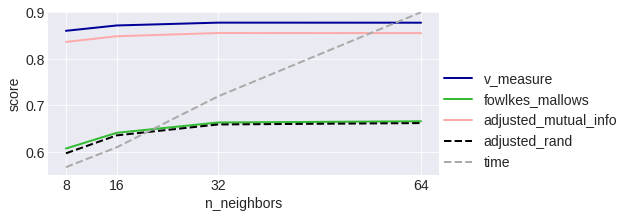

In [ ]:
import matplotlib.pyplot as plt

x_axis = parameters_n_neighbors
axis = (1, 2)
x_axis_name = 'n_neighbors'

plt.figure(figsize=(7, 3))
plt.plot(x_axis, np.mean(V, axis=axis), lw=2, c='#000099', label='v_measure') #  V = #np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
plt.plot(x_axis, np.mean(FM, axis=axis), lw=2, c='#33BB33', label='fowlkes_mallows')
plt.plot(x_axis, np.mean(MI, axis=axis), lw=2, c='#FFAAAA', label='adjusted_mutual_info')
plt.plot(x_axis, np.mean(RS, axis=axis), '--', lw=2, c='#000000', label='adjusted_rand')
t = np.mean(T, axis=axis)
t = 0.9 * t / np.max(t)
plt.plot(x_axis, t, '--', lw=2, c='#AAAAAA', label='time')
plt.xticks(x_axis, x_axis)
plt.xlabel(x_axis_name)
plt.ylabel('score')
plt.legend(loc=(1,0))
plt.ylim([0.55, 0.9])
# plt.xscale('log')
plt.grid()

(0.6, 0.9)

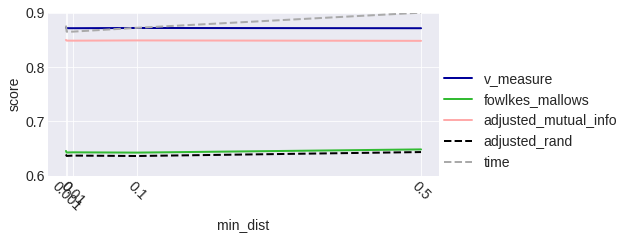

In [ ]:
import matplotlib.pyplot as plt

x_axis = parameters_min_dist
axis = (0, 2)
x_axis_name = 'min_dist'

plt.figure(figsize=(7, 3))
plt.plot(x_axis, np.mean(V, axis=axis), lw=2, c='#000099', label='v_measure') #  V = #np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
plt.plot(x_axis, np.mean(FM, axis=axis), lw=2, c='#33BB33', label='fowlkes_mallows')
plt.plot(x_axis, np.mean(MI, axis=axis), lw=2, c='#FFAAAA', label='adjusted_mutual_info')
plt.plot(x_axis, np.mean(RS, axis=axis), '--', lw=2, c='#000000', label='adjusted_rand')
t = np.mean(T, axis=axis)
t = 0.9 * t / np.max(t)
plt.plot(x_axis, t, '--', lw=2, c='#AAAAAA', label='time')
# plt.xscale('log')
plt.xticks(x_axis, x_axis, rotation=-45)
plt.grid()
plt.xlabel(x_axis_name)
plt.ylabel('score')
plt.legend(loc=(1,0))
plt.ylim([0.6, 0.9])

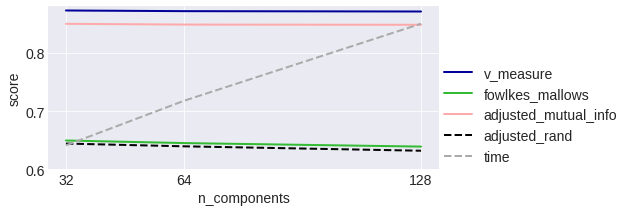

In [ ]:
x_axis = parameters_n_components
axis = (0, 1)
x_axis_name = 'n_components'

plt.figure(figsize=(7, 3))
plt.plot(x_axis, np.mean(V, axis=axis), lw=2, c='#000099', label='v_measure') #  V = #np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
plt.plot(x_axis, np.mean(FM, axis=axis), lw=2, c='#33BB33', label='fowlkes_mallows')
plt.plot(x_axis, np.mean(MI, axis=axis), lw=2, c='#FFAAAA', label='adjusted_mutual_info')
plt.plot(x_axis, np.mean(RS, axis=axis), '--', lw=2, c='#000000', label='adjusted_rand')
t = np.mean(T, axis=axis)
t = 0.5 * t / np.max(t) + 0.35
plt.plot(x_axis, t, '--', lw=2, c='#AAAAAA', label='time')
# plt.xscale('log')
plt.xticks(x_axis, x_axis)
plt.grid()
plt.xlabel(x_axis_name)
plt.ylabel('score')
plt.legend(loc=(1,0))
plt.ylim([0.6, 0.88])
plt.show()

In [ ]:
ind = np.unravel_index(np.argmax(V, axis=None), V.shape)
ind, parameters_n_neighbors[ind[0]], parameters_min_dist[ind[1]], parameters_n_components[ind[2]]

# i=2, j=0, k=0 n_neighbors=32, min_dist=0, n_components=32, V=0.8818, H=0.8744, C=0.8893, NC=151, FM=0.6744, MI=0.8603, RS=0.6703, T=37.5886

((2, 0, 0), 32, 0, 32)

In [ ]:
# СОХРАНЯЕМ

savedata = {'V': V,
            'H': H,
            'C': C,
            'NC': NC,
            'FM': FM,
            'MI': MI,
            'RS': RS,
            'T': T}

np.save('/content/drive/My Drive/clusterdata/climc_umap02cos_save.npy', savedata)

(15250, 64)


## Подбираем параметры DBSCAN в хорошем пространстве

In [ ]:
# параметры
parameters_eps = [0.0001, 0.001, 0.01, 0.1] #
parameters_min_samples = [2, 4, 8, 16, 32, 64] #
parameters_metric = ['cosine', 'euclidean']

# пространство для кластеризации
reducer = umap.UMAP(n_neighbors=32, min_dist=0.0, n_components=32, metric='cosine') # cosine
embedding = reducer.fit_transform(X)

# инициализация
V = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))
H = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))
C = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))
NC =  np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)), dtype=int)
FM = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))
MI = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))
RS = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))
T = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))

# перебор
for i, eps in enumerate(parameters_eps): # tqdm
  for j, min_samples in enumerate(parameters_min_samples):
    for k, metric in enumerate(parameters_metric):

      t0 = time()
      clustering_emb = DBSCAN(eps=eps, min_samples=min_samples, metric=metric).fit(embedding)
      a = clustering_emb.labels_

      V[i, j, k] = v_measure_score(y, a)
      H[i, j, k] =homogeneity_score(y, a)
      C[i, j, k] = completeness_score(y, a)
      NC[i, j, k] = len(np.unique(a))
      FM[i, j, k] = fowlkes_mallows_score(y, a)
      MI[i, j, k] = adjusted_mutual_info_score(y, a)
      RS[i, j, k] = adjusted_rand_score(y, a)
      T[i, j, k] = time() - t0

      print (f"i={i}, j={j}, k={k} eps={eps}, min_samples={min_samples}, metric={metric}, V={np.round(V[i, j, k], 4)}, H={np.round(H[i, j, k], 4)}, C={np.round(C[i, j, k], 4)}, NC={np.round(NC[i, j, k], 4)}, FM={np.round(FM[i, j, k], 4)}, MI={np.round(MI[i, j, k], 4)}, RS={np.round(RS[i, j, k], 4)}, T={np.round(T[i, j, k], 4)}")

i=0, j=0, k=0 eps=0.0001, min_samples=2, metric=cosine, V=0.8029, H=0.7101, C=0.9236, NC=77, FM=0.3867, MI=0.785, RS=0.2838, T=1.6165
i=0, j=0, k=1 eps=0.0001, min_samples=2, metric=euclidean, V=0.0008, H=0.0004, C=0.5337, NC=3, FM=0.0815, MI=0.0002, RS=0.0, T=2.5311
i=0, j=1, k=0 eps=0.0001, min_samples=4, metric=cosine, V=0.8029, H=0.71, C=0.9238, NC=74, FM=0.3867, MI=0.785, RS=0.2838, T=1.1354
i=0, j=1, k=1 eps=0.0001, min_samples=4, metric=euclidean, V=0.0005, H=0.0003, C=0.5459, NC=2, FM=0.0815, MI=0.0001, RS=0.0, T=2.3355
i=0, j=2, k=0 eps=0.0001, min_samples=8, metric=cosine, V=0.8068, H=0.7162, C=0.9236, NC=73, FM=0.3948, MI=0.7891, RS=0.2945, T=1.1388
i=0, j=2, k=1 eps=0.0001, min_samples=8, metric=euclidean, V=0.0, H=0.0, C=1.0, NC=1, FM=0.0816, MI=0.0, RS=0.0, T=2.3147
i=0, j=3, k=0 eps=0.0001, min_samples=16, metric=cosine, V=0.8068, H=0.7162, C=0.9236, NC=73, FM=0.3948, MI=0.7891, RS=0.2945, T=1.1586
i=0, j=3, k=1 eps=0.0001, min_samples=16, metric=euclidean, V=0.0, H=0.0,

In [ ]:
# eps разный для разных метрик !!!
#

print ('cos')
print (np.round(V[:,:,0], 3) * 100)
print ('L2')
print (np.round(V[:,:,1], 3) * 100)

cos
[[80.3 80.3 80.7 80.7 80.9 81. ]
 [58.5 58.5 58.5 58.5 58.4 58.2]
 [40.3 40.3 40.3 40.3 40.3 40.3]
 [ 0.   0.   0.   0.   0.   0. ]]
L2
[[ 0.1  0.1  0.   0.   0.   0. ]
 [ 2.5  0.8  0.4  0.2  0.   0. ]
 [41.7 31.6 18.7  4.5  0.   0. ]
 [84.9 84.4 83.5 81.5 71.5 25.5]]


In [ ]:
print ('cos')
print (np.round(V[:,:,0], 3) * 100)
print ('L2')
print (np.round(V[:,:,1], 3) * 100)

## DBSCAN в исходном пространстве

In [ ]:
# параметры
parameters_eps = [0.1, 0.2, 0.5, 1.0] # [0.0001, 0.001, 0.01, 0.1] #
parameters_min_samples = [2, 4, 8, 16, 32, 64] #
parameters_metric = ['cosine', 'euclidean']

# инициализация
V = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))
H = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))
C = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))
NC =  np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)), dtype=int)
FM = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))
MI = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))
RS = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))
T = np.zeros((len(parameters_eps), len(parameters_min_samples), len(parameters_metric)))

# перебор
for i, eps in enumerate(parameters_eps): # tqdm
  for j, min_samples in enumerate(parameters_min_samples):
    for k, metric in enumerate(parameters_metric):

      t0 = time()
      clustering_emb = DBSCAN(eps=eps, min_samples=min_samples, metric=metric).fit(X)
      a = clustering_emb.labels_

      V[i, j, k] = v_measure_score(y, a)
      H[i, j, k] = homogeneity_score(y, a)
      C[i, j, k] = completeness_score(y, a)
      NC[i, j, k] = len(np.unique(a))
      FM[i, j, k] = fowlkes_mallows_score(y, a)
      MI[i, j, k] = adjusted_mutual_info_score(y, a)
      RS[i, j, k] = adjusted_rand_score(y, a)
      T[i, j, k] = time() - t0

      print (f"i={i}, j={j}, k={k} eps={eps}, min_samples={min_samples}, metric={metric}, V={np.round(V[i, j, k], 4)}, H={np.round(H[i, j, k], 4)}, C={np.round(C[i, j, k], 4)}, NC={np.round(NC[i, j, k], 4)}, FM={np.round(FM[i, j, k], 4)}, MI={np.round(MI[i, j, k], 4)}, RS={np.round(RS[i, j, k], 4)}, T={np.round(T[i, j, k], 4)}")

i=0, j=0, k=0 eps=0.1, min_samples=2, metric=cosine, V=0.5349, H=0.4697, C=0.621, NC=1383, FM=0.063, MI=0.3297, RS=0.0058, T=8.8102
i=0, j=0, k=1 eps=0.1, min_samples=2, metric=euclidean, V=0.0003, H=0.0001, C=0.5068, NC=2, FM=0.0816, MI=0.0, RS=0.0, T=8.3078
i=0, j=1, k=0 eps=0.1, min_samples=4, metric=cosine, V=0.4354, H=0.3254, C=0.6577, NC=495, FM=0.0706, MI=0.2887, RS=0.0036, T=8.4529
i=0, j=1, k=1 eps=0.1, min_samples=4, metric=euclidean, V=0.0, H=0.0, C=1.0, NC=1, FM=0.0816, MI=0.0, RS=0.0, T=9.4362
i=0, j=2, k=0 eps=0.1, min_samples=8, metric=cosine, V=0.2743, H=0.17, C=0.7097, NC=128, FM=0.0782, MI=0.1933, RS=0.002, T=11.5506
i=0, j=2, k=1 eps=0.1, min_samples=8, metric=euclidean, V=0.0, H=0.0, C=1.0, NC=1, FM=0.0816, MI=0.0, RS=0.0, T=8.2109
i=0, j=3, k=0 eps=0.1, min_samples=16, metric=cosine, V=0.1386, H=0.0764, C=0.7412, NC=36, FM=0.0805, MI=0.1004, RS=0.0009, T=5.6239
i=0, j=3, k=1 eps=0.1, min_samples=16, metric=euclidean, V=0.0, H=0.0, C=1.0, NC=1, FM=0.0816, MI=0.0, RS

In [ ]:
# Для стандартной сетки что-то совсем плохо...
print ('cos')
print (np.round(V[:,:,0], 3) * 100)
print ('L2')
print (np.round(V[:,:,1], 3) * 100)

cos
[[ 0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0. ]
 [ 3.1  0.2  0.   0.   0.   0. ]
 [53.5 43.5 27.4 13.9  3.7  0. ]]
L2
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [ ]:
# для новой сетки тоже не очень...
print ('cos')
print (np.round(V[:,:,0], 3) * 100)
print ('L2')
print (np.round(V[:,:,1], 3) * 100)

cos
[[53.5 43.5 27.4 13.9  3.7  0. ]
 [69.4 65.6 58.3 49.  33.  13. ]
 [ 1.8  1.9  2.3  2.5  3.   4.4]
 [ 0.   0.   0.   0.   0.   0. ]]
L2
[[0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]
 [3.  0.2 0.  0.  0.  0. ]]


## Пробуем SVD / PCA вместо UMAP

Тут была какая-то чертовщина с качеством - но в итоге проблема в SVDS

In [ ]:
from scipy.sparse.linalg import svds
U, L, V = svds(X, k=383)

# чтобы правильно упорядочить столбцы, а то порядок не гарантирован
i = np.argsort(-L)
U = U[:, i]

In [ ]:
L = L[i]

In [ ]:
# А это PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=150)
U = pca.fit_transform(X)

In [ ]:
# случайная проекция
U = (X @ np.random.randn(768, 150))
# X.shape 15250, 768)

In [ ]:
X.shape

NameError: ignored

In [ ]:
%%time
# t-SNE
from sklearn.manifold import TSNE

U = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(X)

# from fastTSNE import TSNE
# 1min 46s

CPU times: user 1min 48s, sys: 1.12 s, total: 1min 49s
Wall time: 1min 45s


In [ ]:
from time import time

In [ ]:
X.shape

(15250, 768)

In [ ]:
# Эксперименты - пробуем разные параметры UMAP

# параметры

#parameters_n_components = [10, 25, 50, 75, 100, 125, 150]
# parameters_n_components = [1, 2]
parameters_n_components = [2, 4, 8, 16, 32, 64]

# инициализация
V = np.zeros(( len(parameters_n_components)))
H = np.zeros(( len(parameters_n_components)))
C = np.zeros(( len(parameters_n_components)))
NC =  np.zeros(( len(parameters_n_components)), dtype=int)
FM = np.zeros(( len(parameters_n_components)))
MI = np.zeros(( len(parameters_n_components)))
RS = np.zeros(( len(parameters_n_components)))
T = np.zeros(( len(parameters_n_components)))

l = len(np.unique(y))
print (f'число кластеров = {l}')

# перебор
for k, n_components in enumerate(parameters_n_components):
  t0 = time()
  reducer = umap.UMAP(n_neighbors=32, min_dist=0.1, n_components=n_components, metric='euclidean') # cosine
  U = reducer.fit_transform(X)
  clustering_emb = KMeans(n_clusters=l).fit(U)
  #clustering_emb = KMeans(n_clusters=l).fit(U[:, :n_components])
  ########### clustering_emb = KMeans(n_clusters=l).fit(U[:, :n_components] @ np.diag(np.sqrt(L[:n_components])))
  a = clustering_emb.labels_

  V[k] = v_measure_score(y, a)
  H[k] =homogeneity_score(y, a)
  C[k] = completeness_score(y, a)
  NC[k] = len(np.unique(a))
  FM[k] = fowlkes_mallows_score(y, a)
  MI[k] = adjusted_mutual_info_score(y, a)
  RS[k] = adjusted_rand_score(y, a)
  T[k] = time() - t0

  print (f"k={k}, n_components={n_components}, V={np.round(V[k], 4)}, H={np.round(H[k], 4)}, C={np.round(C[k], 4)}, NC={np.round(NC[k], 4)}, FM={np.round(FM[k], 4)}, MI={np.round(MI[k], 4)}, RS={np.round(RS[k], 4)}, T={np.round(T[k], 4)}")

число кластеров = 151
k=0, n_components=2, V=0.9337, H=0.9289, C=0.9385, NC=151, FM=0.7985, MI=0.9214, RS=0.7962, T=44.7608
k=1, n_components=4, V=0.9343, H=0.9296, C=0.939, NC=151, FM=0.8003, MI=0.9221, RS=0.7981, T=25.5373
k=2, n_components=8, V=0.9318, H=0.9265, C=0.9371, NC=151, FM=0.7898, MI=0.9191, RS=0.7873, T=27.6455
k=3, n_components=16, V=0.9368, H=0.9305, C=0.9432, NC=151, FM=0.8035, MI=0.9253, RS=0.8007, T=38.6579
k=4, n_components=32, V=0.9345, H=0.9302, C=0.9388, NC=151, FM=0.8015, MI=0.9223, RS=0.7995, T=45.2
k=5, n_components=64, V=0.9326, H=0.9264, C=0.9389, NC=151, FM=0.7876, MI=0.9202, RS=0.7847, T=70.4475


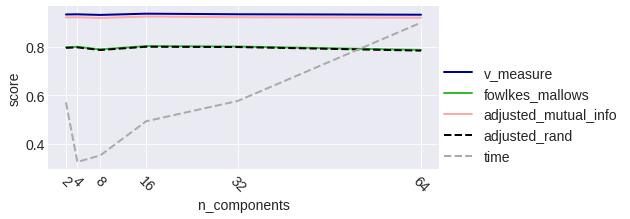

In [ ]:
import matplotlib.pyplot as plt

x_axis = parameters_n_components
# axis = (0, 2)
x_axis_name = 'n_components'

plt.figure(figsize=(7, 3))
plt.plot(x_axis, V, lw=2, c='#000099', label='v_measure') #  V = #np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
plt.plot(x_axis, FM, lw=2, c='#33BB33', label='fowlkes_mallows')
plt.plot(x_axis, MI, lw=2, c='#FFAAAA', label='adjusted_mutual_info')
plt.plot(x_axis, RS, '--', lw=2, c='#000000', label='adjusted_rand')
# t = np.mean(T, axis=axis)
t = T.copy()
t = 0.9 * t / np.max(t)
plt.plot(x_axis, t, '--', lw=2, c='#AAAAAA', label='time')
# plt.xscale('log')
plt.xticks(x_axis, x_axis, rotation=-45)
plt.grid()
plt.xlabel(x_axis_name)
plt.ylabel('score')
plt.legend(loc=(1,0))
# plt.ylim([0.6, 0.9])

In [ ]:
# вывод
# иcправил SVD

число кластеров = 151
k=0, n_components=10, V=0.7347, H=0.7316, C=0.7378, NC=151, FM=0.4166, MI=0.6853, RS=0.4122, T=16.8355
k=1, n_components=25, V=0.8243, H=0.8207, C=0.828, NC=151, FM=0.5776, MI=0.7916, RS=0.5742, T=10.3723
k=2, n_components=50, V=0.8286, H=0.8229, C=0.8343, NC=151, FM=0.5802, MI=0.797, RS=0.576, T=22.3754
k=3, n_components=75, V=0.8208, H=0.8145, C=0.8272, NC=151, FM=0.5574, MI=0.7879, RS=0.5528, T=19.366
k=4, n_components=100, V=0.8204, H=0.8118, C=0.8291, NC=151, FM=0.5565, MI=0.7879, RS=0.5506, T=16.752
k=5, n_components=125, V=0.802, H=0.793, C=0.8113, NC=151, FM=0.5138, MI=0.7662, RS=0.5072, T=20.612
k=6, n_components=150, V=0.8027, H=0.79, C=0.8158, NC=151, FM=0.5031, MI=0.7678, RS=0.4936, T=23.9631


# X @ L

число кластеров = 151
k=0, n_components=10, V=0.7513, H=0.7477, C=0.7549, NC=151, FM=0.449, MI=0.7051, RS=0.4447, T=12.3307
k=1, n_components=25, V=0.8322, H=0.827, C=0.8375, NC=151, FM=0.5828, MI=0.8012, RS=0.5788, T=9.9408
k=2, n_components=50, V=0.8497, H=0.8443, C=0.8552, NC=151, FM=0.6171, MI=0.8219, RS=0.6132, T=10.9739
k=3, n_components=75, V=0.8568, H=0.8504, C=0.8634, NC=151, FM=0.6231, MI=0.8306, RS=0.6189, T=12.988
k=4, n_components=100, V=0.8602, H=0.8543, C=0.8661, NC=151, FM=0.6336, MI=0.8344, RS=0.6297, T=14.8174
k=5, n_components=125, V=0.8634, H=0.8555, C=0.8714, NC=151, FM=0.63, MI=0.8384, RS=0.6249, T=18.6306
k=6, n_components=150, V=0.8603, H=0.8538, C=0.8669, NC=151, FM=0.6294, MI=0.8346, RS=0.6252, T=29.2496

# X @ sqrt(L)

число кластеров = 151
k=0, n_components=10, V=0.7455, H=0.7423, C=0.7487, NC=151, FM=0.4421, MI=0.6981, RS=0.4379, T=19.2563
k=1, n_components=25, V=0.8317, H=0.8284, C=0.835, NC=151, FM=0.5919, MI=0.8003, RS=0.5887, T=10.4233
k=2, n_components=50, V=0.8426, H=0.8367, C=0.8487, NC=151, FM=0.606, MI=0.8137, RS=0.6018, T=10.6263
k=3, n_components=75, V=0.8378, H=0.8312, C=0.8444, NC=151, FM=0.5804, MI=0.808, RS=0.5758, T=12.9337
k=4, n_components=100, V=0.843, H=0.8362, C=0.8499, NC=151, FM=0.597, MI=0.8142, RS=0.5924, T=14.9503
k=5, n_components=125, V=0.8435, H=0.8348, C=0.8524, NC=151, FM=0.5836, MI=0.8151, RS=0.5776, T=18.3147
k=6, n_components=150, V=0.8394, H=0.8303, C=0.8487, NC=151, FM=0.5804, MI=0.8104, RS=0.5744, T=22.4558

# PCA
число кластеров = 151
k=0, n_components=10, V=0.7534, H=0.7498, C=0.757, NC=151, FM=0.4486, MI=0.7075, RS=0.4443, T=23.7057
k=1, n_components=25, V=0.8341, H=0.8299, C=0.8383, NC=151, FM=0.5969, MI=0.8033, RS=0.5934, T=16.5884
k=2, n_components=50, V=0.8565, H=0.8508, C=0.8623, NC=151, FM=0.6275, MI=0.8301, RS=0.6236, T=17.5572
k=3, n_components=75, V=0.865, H=0.859, C=0.871, NC=151, FM=0.6432, MI=0.8401, RS=0.6392, T=13.6609
k=4, n_components=100, V=0.8613, H=0.8548, C=0.8679, NC=151, FM=0.6302, MI=0.8358, RS=0.626, T=14.1136
k=5, n_components=125, V=0.8578, H=0.8501, C=0.8657, NC=151, FM=0.622, MI=0.832, RS=0.6173, T=16.7779
k=6, n_components=150, V=0.8591, H=0.8506, C=0.8678, NC=151, FM=0.6182, MI=0.8335, RS=0.6127, T=21.9443

# случайные проекции (но тут T5)
k=0, n_components=10, V=0.5316, H=0.5299, C=0.5332, NC=151, FM=0.2017, MI=0.4439, RS=0.1961, T=21.8271
k=1, n_components=25, V=0.7351, H=0.7329, C=0.7373, NC=151, FM=0.4707, MI=0.6855, RS=0.4669, T=13.983
k=2, n_components=50, V=0.8419, H=0.8392, C=0.8446, NC=151, FM=0.6417, MI=0.8123, RS=0.639, T=14.4978
k=3, n_components=75, V=0.8774, H=0.8726, C=0.8823, NC=151, FM=0.684, MI=0.8547, RS=0.6809, T=14.5058
k=4, n_components=100, V=0.895, H=0.8908, C=0.8993, NC=151, FM=0.7152, MI=0.8755, RS=0.7125, T=15.9028
k=5, n_components=125, V=0.893, H=0.8882, C=0.8979, NC=151, FM=0.7072, MI=0.8732, RS=0.7043, T=18.1399
k=6, n_components=150, V=0.9096, H=0.9045, C=0.9147, NC=151, FM=0.745, MI=0.8928, RS=0.7423, T=20.5817

# t-SNE
k=0, n_components=1, V=0.5666, H=0.5637, C=0.5695, NC=151, FM=0.1256, MI=0.4864, RS=0.1193, T=2.729
k=1, n_components=2, V=0.9186, H=0.9166, C=0.9205, NC=151, FM=0.7744, MI=0.9033, RS=0.7727, T=3.378

# T5 + UMAP
число кластеров = 151
k=0, n_components=2, V=0.9337, H=0.9289, C=0.9385, NC=151, FM=0.7985, MI=0.9214, RS=0.7962, T=44.7608
k=1, n_components=4, V=0.9343, H=0.9296, C=0.939, NC=151, FM=0.8003, MI=0.9221, RS=0.7981, T=25.5373
k=2, n_components=8, V=0.9318, H=0.9265, C=0.9371, NC=151, FM=0.7898, MI=0.9191, RS=0.7873, T=27.6455
k=3, n_components=16, V=0.9368, H=0.9305, C=0.9432, NC=151, FM=0.8035, MI=0.9253, RS=0.8007, T=38.6579
k=4, n_components=32, V=0.9345, H=0.9302, C=0.9388, NC=151, FM=0.8015, MI=0.9223, RS=0.7995, T=45.2
k=5, n_components=64, V=0.9326, H=0.9264, C=0.9389, NC=151, FM=0.7876, MI=0.9202, RS=0.7847, T=70.4475

(15250, 384)

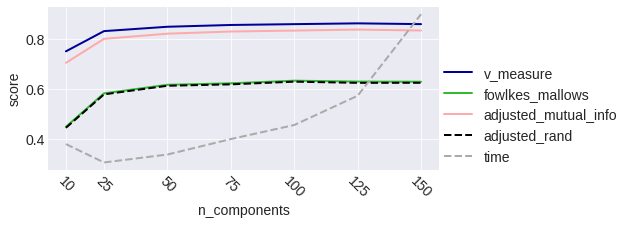

In [ ]:
# ЕСЛИ УМНОЖАТЬ НА ДИАГОНАЛЬНУЮ МАТРИЦУ L

import matplotlib.pyplot as plt

x_axis = parameters_n_components
# axis = (0, 2)
x_axis_name = 'n_components'

plt.figure(figsize=(7, 3))
plt.plot(x_axis, V, lw=2, c='#000099', label='v_measure') #  V = #np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
plt.plot(x_axis, FM, lw=2, c='#33BB33', label='fowlkes_mallows')
plt.plot(x_axis, MI, lw=2, c='#FFAAAA', label='adjusted_mutual_info')
plt.plot(x_axis, RS, '--', lw=2, c='#000000', label='adjusted_rand')
# t = np.mean(T, axis=axis)
t = T.copy()
t = 0.9 * t / np.max(t)
plt.plot(x_axis, t, '--', lw=2, c='#AAAAAA', label='time')
# plt.xscale('log')
plt.xticks(x_axis, x_axis, rotation=-45)
plt.grid()
plt.xlabel(x_axis_name)
plt.ylabel('score')
plt.legend(loc=(1,0))
# plt.ylim([0.6, 0.9])

### На части делать UMAP

In [ ]:
# Эксперименты - пробуем разные параметры UMAP

# параметры

#parameters_n_components = [10, 25, 50, 75, 100, 125, 150]
# parameters_n_components = [1, 2]
parameters_n_components = [2, 4, 8, 16, 32, 64]

# инициализация
V = np.zeros(( len(parameters_n_components)))
H = np.zeros(( len(parameters_n_components)))
C = np.zeros(( len(parameters_n_components)))
NC =  np.zeros(( len(parameters_n_components)), dtype=int)
FM = np.zeros(( len(parameters_n_components)))
MI = np.zeros(( len(parameters_n_components)))
RS = np.zeros(( len(parameters_n_components)))
T = np.zeros(( len(parameters_n_components)))

V2 = np.zeros(( len(parameters_n_components)))
H2 = np.zeros(( len(parameters_n_components)))
C2 = np.zeros(( len(parameters_n_components)))
NC2 =  np.zeros(( len(parameters_n_components)), dtype=int)
FM2 = np.zeros(( len(parameters_n_components)))
MI2 = np.zeros(( len(parameters_n_components)))
RS2 = np.zeros(( len(parameters_n_components)))
T2 = np.zeros(( len(parameters_n_components)))

l = len(np.unique(y))
print (f'число кластеров = {l}')

# перебор
for k, n_components in enumerate(parameters_n_components):
  t0 = time()
  reducer = umap.UMAP(n_neighbors=32, min_dist=0.1, n_components=n_components, metric='euclidean') # cosine
  reducer.fit(X[:2000, :])
  U = reducer.transform(X)
  clustering_emb = KMeans(n_clusters=l).fit(U)
  #clustering_emb = KMeans(n_clusters=l).fit(U[:, :n_components])
  ########### clustering_emb = KMeans(n_clusters=l).fit(U[:, :n_components] @ np.diag(np.sqrt(L[:n_components])))
  a = clustering_emb.labels_

  V[k],V2[k]  = v_measure_score(y[:2000], a[:2000]), v_measure_score(y[2000:], a[2000:])
  H[k], H2[k] = homogeneity_score(y[:2000], a[:2000]), homogeneity_score(y[2000:], a[2000:])
  C[k], C2[k] = completeness_score(y[:2000], a[:2000]), completeness_score(y[2000:], a[2000:])
  NC[k], NC2[k] = len(np.unique(a[:2000])), len(np.unique(a[2000:]))
  FM[k], FM2[k] = fowlkes_mallows_score(y[:2000], a[:2000]), fowlkes_mallows_score(y[2000:], a[2000:])
  MI[k], MI2[k] = adjusted_mutual_info_score(y[:2000], a[:2000]), adjusted_mutual_info_score(y[2000:], a[2000:])
  RS[k], RS2[k] = adjusted_rand_score(y[:2000], a[:2000]), adjusted_rand_score(y[2000:], a[2000:])
  T[k] = time() - t0

  print (f"k={k}, n_components={n_components}, V={np.round(V[k], 4)}, H={np.round(H[k], 4)}, C={np.round(C[k], 4)}, NC={np.round(NC[k], 4)}, FM={np.round(FM[k], 4)}, MI={np.round(MI[k], 4)}, RS={np.round(RS[k], 4)}, T={np.round(T[k], 4)}")
  print (f" V={np.round(V2[k], 4)}, H={np.round(H2[k], 4)}, C={np.round(C2[k], 4)}, NC={np.round(NC2[k], 4)}, FM={np.round(FM2[k], 4)}, MI={np.round(MI2[k], 4)}, RS={np.round(RS2[k], 4)}, T={np.round(T2[k], 4)}")

число кластеров = 151
k=0, n_components=2, V=0.8795, H=0.9806, C=0.7973, NC=47, FM=0.7042, MI=0.8705, RS=0.6596, T=106.7456
 V=0.4597, H=0.448, C=0.4721, NC=151, FM=0.1368, MI=0.3677, RS=0.1199, T=0.0
k=1, n_components=4, V=0.9448, H=0.9756, C=0.9159, NC=29, FM=0.8808, MI=0.9422, RS=0.8731, T=119.3989
 V=0.5093, H=0.4823, C=0.5396, NC=151, FM=0.1646, MI=0.4323, RS=0.1327, T=0.0
k=2, n_components=8, V=0.9518, H=0.9776, C=0.9273, NC=28, FM=0.9041, MI=0.9496, RS=0.8982, T=162.7389
 V=0.5227, H=0.4966, C=0.5518, NC=151, FM=0.1769, MI=0.4486, RS=0.1493, T=0.0
k=3, n_components=16, V=0.9488, H=0.9779, C=0.9214, NC=26, FM=0.8972, MI=0.9466, RS=0.8901, T=259.9015
 V=0.527, H=0.4979, C=0.5598, NC=151, FM=0.1724, MI=0.4524, RS=0.1384, T=0.0
k=4, n_components=32, V=0.9459, H=0.9737, C=0.9197, NC=26, FM=0.8929, MI=0.9436, RS=0.8856, T=441.368
 V=0.5282, H=0.4989, C=0.5613, NC=151, FM=0.1755, MI=0.4541, RS=0.1412, T=0.0
k=5, n_components=64, V=0.9593, H=0.9773, C=0.942, NC=27, FM=0.9199, MI=0.9576,

## UMAP + Standartisation + k-means

Перебираем параметры UMAP


Сначала стандартизация после UMAP - тут почти также, как без стандартизации!

In [ ]:
# Эксперименты - пробуем разные параметры UMAP

# Стандартизация после UMAP!

# параметры
parameters_n_neighbors = [16, 32, 64] # 4, 8,
parameters_min_dist = [0, 0.001, 0.01] # , 0.1, 0.5, 1.0
parameters_n_components = [32, 64, 128] # 2,

# инициализация
V = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
H = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
C = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
NC =  np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)), dtype=int)
FM = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
MI = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
RS = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
T = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))

l = len(np.unique(y))
print (f'число кластеров = {l}')

# СТАНДАРТИЗАЦИЯ
scaler = StandardScaler()

# перебор
for i, n_neighbors in enumerate(parameters_n_neighbors): # tqdm
  for j, min_dist in enumerate(parameters_min_dist):
    for k, n_components in enumerate(parameters_n_components):

      t0 = time()
      reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric='euclidean') # cosine
      embedding = reducer.fit_transform(X)
      embedding = scaler.fit_transform(embedding)
      clustering_emb = KMeans(n_clusters=l).fit(embedding)
      a = clustering_emb.labels_

      V[i, j, k] = v_measure_score(y, a)
      H[i, j, k] =homogeneity_score(y, a)
      C[i, j, k] = completeness_score(y, a)
      NC[i, j, k] = len(np.unique(a))
      FM[i, j, k] = fowlkes_mallows_score(y, a)
      MI[i, j, k] = adjusted_mutual_info_score(y, a)
      RS[i, j, k] = adjusted_rand_score(y, a)
      T[i, j, k] = time() - t0

      print (f"i={i}, j={j}, k={k} n_neighbors={n_neighbors}, min_dist={min_dist}, n_components={n_components}, V={np.round(V[i, j, k], 4)}, H={np.round(H[i, j, k], 4)}, C={np.round(C[i, j, k], 4)}, NC={np.round(NC[i, j, k], 4)}, FM={np.round(FM[i, j, k], 4)}, MI={np.round(MI[i, j, k], 4)}, RS={np.round(RS[i, j, k], 4)}, T={np.round(T[i, j, k], 4)}")

число кластеров = 151
i=0, j=0, k=0 n_neighbors=16, min_dist=0, n_components=32, V=0.8692, H=0.8583, C=0.8804, NC=151, FM=0.6344, MI=0.8459, RS=0.6279, T=36.0171
i=0, j=0, k=1 n_neighbors=16, min_dist=0, n_components=64, V=0.8658, H=0.8557, C=0.8762, NC=151, FM=0.6257, MI=0.8418, RS=0.6197, T=37.2969
i=0, j=0, k=2 n_neighbors=16, min_dist=0, n_components=128, V=0.8606, H=0.845, C=0.8769, NC=151, FM=0.5899, MI=0.8364, RS=0.5793, T=55.4245
i=0, j=1, k=0 n_neighbors=16, min_dist=0.001, n_components=32, V=0.8681, H=0.8575, C=0.879, NC=151, FM=0.631, MI=0.8445, RS=0.6245, T=28.4759
i=0, j=1, k=1 n_neighbors=16, min_dist=0.001, n_components=64, V=0.8669, H=0.8559, C=0.8782, NC=151, FM=0.6195, MI=0.843, RS=0.6123, T=37.8797
i=0, j=1, k=2 n_neighbors=16, min_dist=0.001, n_components=128, V=0.8658, H=0.8505, C=0.8817, NC=151, FM=0.6055, MI=0.8424, RS=0.5948, T=54.8898
i=0, j=2, k=0 n_neighbors=16, min_dist=0.01, n_components=32, V=0.8694, H=0.8585, C=0.8806, NC=151, FM=0.6344, MI=0.8461, RS=0.6

In [ ]:
ind = np.unravel_index(np.argmax(V, axis=None), V.shape)
ind, parameters_n_neighbors[ind[0]], parameters_min_dist[ind[1]], parameters_n_components[ind[2]]

# i=1, j=1, k=0 n_neighbors=32, min_dist=0.001, n_components=32, V=0.87, H=0.8607, C=0.8794, NC=151, FM=0.6396, MI=0.8465, RS=0.634, T=33.2844

((1, 1, 0), 32, 0.001, 32)

In [ ]:
savedata = {'V': V,
            'H': H,
            'C': C,
            'NC': NC,
            'FM': FM,
            'MI': MI,
            'RS': RS,
            'T': T}

np.save('/content/drive/My Drive/clusterdata/climc_umapstandart03_save.npy', savedata)

(0.4, 0.9)

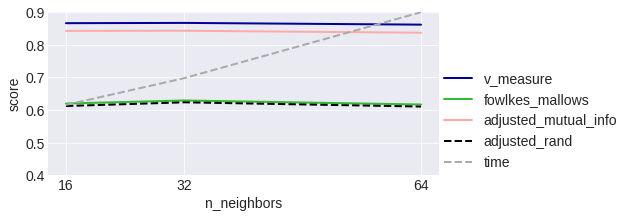

In [ ]:
import matplotlib.pyplot as plt

x_axis = parameters_n_neighbors
axis = (1, 2)
x_axis_name = 'n_neighbors'

plt.figure(figsize=(7, 3))
plt.plot(x_axis, np.mean(V, axis=axis), lw=2, c='#000099', label='v_measure') #  V = #np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
plt.plot(x_axis, np.mean(FM, axis=axis), lw=2, c='#33BB33', label='fowlkes_mallows')
plt.plot(x_axis, np.mean(MI, axis=axis), lw=2, c='#FFAAAA', label='adjusted_mutual_info')
plt.plot(x_axis, np.mean(RS, axis=axis), '--', lw=2, c='#000000', label='adjusted_rand')
t = np.mean(T, axis=axis)
t = 0.9 * t / np.max(t)
plt.plot(x_axis, t, '--', lw=2, c='#AAAAAA', label='time')
# plt.xscale('log')
plt.xticks(x_axis, x_axis)
plt.grid()
plt.xlabel(x_axis_name)
plt.ylabel('score')
plt.legend(loc=(1,0))
plt.ylim([0.4, 0.9])

## Стандартизация + UMAP + k-means

In [ ]:
# Эксперименты - пробуем разные параметры UMAP

# СТАНДАРТИЗАЦИЯ
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)


# параметры
parameters_n_neighbors = [16, 32, 64] # 4, 8,
parameters_min_dist = [0, 0.001, 0.01] # , 0.1, 0.5, 1.0
parameters_n_components = [32, 64, 128] # 2,

# инициализация
V = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
H = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
C = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
NC =  np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)), dtype=int)
FM = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
MI = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
RS = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
T = np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))

l = len(np.unique(y))
print (f'число кластеров = {l}')



# перебор
for i, n_neighbors in enumerate(parameters_n_neighbors): # tqdm
  for j, min_dist in enumerate(parameters_min_dist):
    for k, n_components in enumerate(parameters_n_components):

      t0 = time()
      reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric='euclidean') # cosine
      embedding = reducer.fit_transform(X_scale)
      clustering_emb = KMeans(n_clusters=l).fit(embedding)
      a = clustering_emb.labels_

      V[i, j, k] = v_measure_score(y, a)
      H[i, j, k] =homogeneity_score(y, a)
      C[i, j, k] = completeness_score(y, a)
      NC[i, j, k] = len(np.unique(a))
      FM[i, j, k] = fowlkes_mallows_score(y, a)
      MI[i, j, k] = adjusted_mutual_info_score(y, a)
      RS[i, j, k] = adjusted_rand_score(y, a)
      T[i, j, k] = time() - t0

      print (f"i={i}, j={j}, k={k} n_neighbors={n_neighbors}, min_dist={min_dist}, n_components={n_components}, V={np.round(V[i, j, k], 4)}, H={np.round(H[i, j, k], 4)}, C={np.round(C[i, j, k], 4)}, NC={np.round(NC[i, j, k], 4)}, FM={np.round(FM[i, j, k], 4)}, MI={np.round(MI[i, j, k], 4)}, RS={np.round(RS[i, j, k], 4)}, T={np.round(T[i, j, k], 4)}")

число кластеров = 151
i=0, j=0, k=0 n_neighbors=16, min_dist=0, n_components=32, V=0.8631, H=0.8528, C=0.8736, NC=151, FM=0.6242, MI=0.8386, RS=0.6181, T=35.4864
i=0, j=0, k=1 n_neighbors=16, min_dist=0, n_components=64, V=0.8646, H=0.8545, C=0.8749, NC=151, FM=0.6289, MI=0.8403, RS=0.623, T=36.5384
i=0, j=0, k=2 n_neighbors=16, min_dist=0, n_components=128, V=0.8652, H=0.8536, C=0.877, NC=151, FM=0.6221, MI=0.8412, RS=0.615, T=57.1516
i=0, j=1, k=0 n_neighbors=16, min_dist=0.001, n_components=32, V=0.8662, H=0.8571, C=0.8755, NC=151, FM=0.6347, MI=0.8421, RS=0.6293, T=27.5982
i=0, j=1, k=1 n_neighbors=16, min_dist=0.001, n_components=64, V=0.8657, H=0.8559, C=0.8757, NC=151, FM=0.6289, MI=0.8415, RS=0.6229, T=37.2388
i=0, j=1, k=2 n_neighbors=16, min_dist=0.001, n_components=128, V=0.867, H=0.8542, C=0.8801, NC=151, FM=0.6258, MI=0.8436, RS=0.618, T=55.145
i=0, j=2, k=0 n_neighbors=16, min_dist=0.01, n_components=32, V=0.8658, H=0.8561, C=0.8757, NC=151, FM=0.6306, MI=0.8417, RS=0.624

In [ ]:
ind = np.unravel_index(np.argmax(V, axis=None), V.shape)
ind, parameters_n_neighbors[ind[0]], parameters_min_dist[ind[1]], parameters_n_components[ind[2]]
# i=2, j=1, k=1 n_neighbors=64, min_dist=0.001, n_components=64, V=0.8682, H=0.8609, C=0.8757, NC=151, FM=0.6503, MI=0.8443, RS=0.646, T=57.2074

((2, 1, 1), 64, 0.001, 64)

(0.4, 0.9)

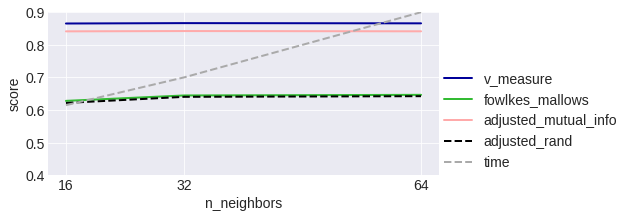

In [ ]:
import matplotlib.pyplot as plt

x_axis = parameters_n_neighbors
axis = (1, 2)
x_axis_name = 'n_neighbors'

plt.figure(figsize=(7, 3))
plt.plot(x_axis, np.mean(V, axis=axis), lw=2, c='#000099', label='v_measure') #  V = #np.zeros((len(parameters_n_neighbors), len(parameters_min_dist), len(parameters_n_components)))
plt.plot(x_axis, np.mean(FM, axis=axis), lw=2, c='#33BB33', label='fowlkes_mallows')
plt.plot(x_axis, np.mean(MI, axis=axis), lw=2, c='#FFAAAA', label='adjusted_mutual_info')
plt.plot(x_axis, np.mean(RS, axis=axis), '--', lw=2, c='#000000', label='adjusted_rand')
t = np.mean(T, axis=axis)
t = 0.9 * t / np.max(t)
plt.plot(x_axis, t, '--', lw=2, c='#AAAAAA', label='time')
# plt.xscale('log')
plt.xticks(x_axis, x_axis)
plt.grid()
plt.xlabel(x_axis_name)
plt.ylabel('score')
plt.legend(loc=(1,0))
plt.ylim([0.4, 0.9])

In [ ]:
savedata = {'V': V,
            'H': H,
            'C': C,
            'NC': NC,
            'FM': FM,
            'MI': MI,
            'RS': RS,
            'T': T}

np.save('/content/drive/My Drive/clusterdata/climc_standartumap04_save.npy', savedata)

In [ ]:
i=0, j=0, k=0 n_neighbors=4, min_dist=0, n_components=2, V=0.7286, H=0.721, C=0.7364, NC=151, FM=0.3702, MI=0.6795, RS=0.3638, T=15.6796
i=0, j=0, k=1 n_neighbors=4, min_dist=0, n_components=32, V=0.7687, H=0.7447, C=0.7944, NC=151, FM=0.3993, MI=0.7301, RS=0.3761, T=24.0184
i=0, j=0, k=2 n_neighbors=4, min_dist=0, n_components=64, V=0.7963, H=0.7675, C=0.8273, NC=151, FM=0.4585, MI=0.7641, RS=0.4345, T=34.4921
i=0, j=0, k=3 n_neighbors=4, min_dist=0, n_components=128, V=0.7964, H=0.7646, C=0.831, NC=151, FM=0.4433, MI=0.7643, RS=0.4137, T=56.2192
i=0, j=1, k=0 n_neighbors=4, min_dist=0.001, n_components=2, V=0.7299, H=0.7228, C=0.7371, NC=151, FM=0.3744, MI=0.6807, RS=0.3683, T=15.0336
i=0, j=1, k=1 n_neighbors=4, min_dist=0.001, n_components=32, V=0.7673, H=0.7456, C=0.7904, NC=151, FM=0.3994, MI=0.7278, RS=0.3788, T=23.1076
i=0, j=1, k=2 n_neighbors=4, min_dist=0.001, n_components=64, V=0.8016, H=0.7721, C=0.8335, NC=151, FM=0.4645, MI=0.7706, RS=0.44, T=33.6041
i=0, j=1, k=3 n_neighbors=4, min_dist=0.001, n_components=128, V=0.79, H=0.7566, C=0.8265, NC=151, FM=0.4257, MI=0.7571, RS=0.3929, T=55.3757
i=0, j=2, k=0 n_neighbors=4, min_dist=0.01, n_components=2, V=0.731, H=0.7243, C=0.7377, NC=151, FM=0.377, MI=0.682, RS=0.3712, T=13.0621
i

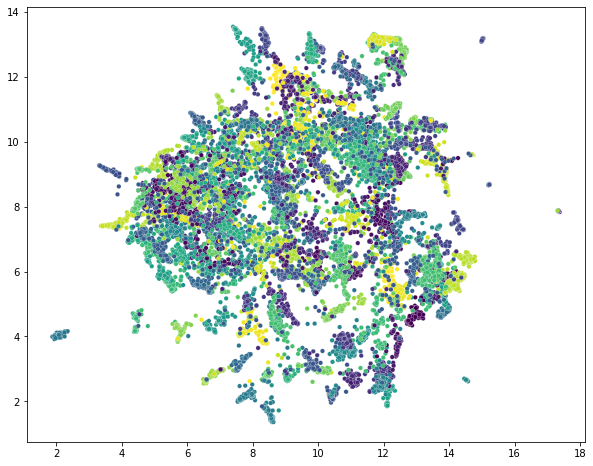

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0],
            embedding[:, 1],
            20,
            y,
            lw=0.2,
            edgecolor='w')

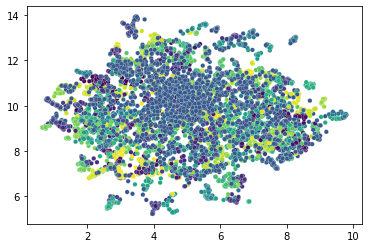

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(embedding[:, 0],
            embedding[:, 1],
            20,
            y,
            lw=0.2,
            edgecolor='w')

# Автокодировщик

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
import torch.nn as nn

enc = nn.Sequential(nn.Linear(768, 700, bias=False),
                    nn.BatchNorm1d(700),
                    nn.ReLU(),
                    nn.Linear(700, 500, bias=False),
                    nn.BatchNorm1d(500),
                    nn.ReLU(),
                    nn.Linear(500, 300, bias=False),
                    nn.BatchNorm1d(300),
                    nn.ReLU(),
                    nn.Linear(300, 100, bias=False),
                    nn.BatchNorm1d(100),
                    nn.ReLU(),
                    nn.Linear(100, 64))

dec = nn.Sequential(nn.Linear(64, 100, bias=False),
                    nn.BatchNorm1d(100),
                    nn.ReLU(),
                    nn.Linear(100, 300, bias=False),
                    nn.BatchNorm1d(300),
                    nn.ReLU(),
                    nn.Linear(300, 500, bias=False),
                    nn.BatchNorm1d(500),
                    nn.ReLU(),
                    nn.Linear(500, 700, bias=False),
                    nn.BatchNorm1d(700),
                    nn.ReLU(),
                    nn.Linear(700, 768))



class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = enc
        self.decoder = dec

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def get_n_params(model):
    """
    число параметров
    """
    np = 0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

model = Autoencoder().to(device)
criterion = nn.MSELoss()

get_n_params(model)

2155232

In [ ]:
torch.tensor(y).shape

torch.Size([15250])

In [ ]:
import torch.utils.data as data

class MyDataset(data.Dataset):

    def __init__(self, X, y):
        """
        Inputs:
            size - число точек
            std - уровень шума
        """
        super().__init__()
        self.X = torch.tensor(X.astype(np.float32))
        self.y = torch.tensor(y.astype(np.int)) # тут надо тип сменить


    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # idx-й элемент датасета
        return self.X[idx], self.y[idx]

data_loader = data.DataLoader(MyDataset(X, y), batch_size=1024, shuffle=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


In [ ]:
learning_rate = 3e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

num_epochs = 500
losses = []
# do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    total_loss = 0
    i_batch = 0
    for data in data_loader:
        x, _ = data
        x = x.to(device)
        # ===================forward=====================
        output = model(x)
        loss = criterion(output, x)
        total_loss += loss.item()
        i_batch += 1
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    if np.mod(epoch + 1, 100)==0:
      print(f'epoch [{epoch + 1}/{num_epochs}], loss:{total_loss/i_batch:.4f}')
    losses.append(total_loss/i_batch)


# loss:0.0175

epoch [100/500], loss:0.0152
epoch [200/500], loss:0.0155
epoch [300/500], loss:0.0098
epoch [400/500], loss:0.0094
epoch [500/500], loss:0.0103


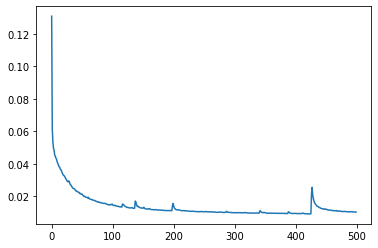

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)

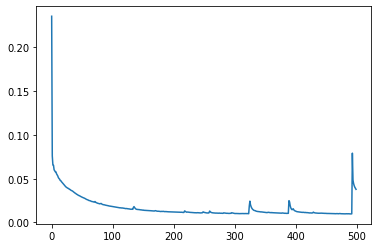

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [ ]:
learning_rate = 1e-4

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

num_epochs = 100
losses = []
# do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    total_loss = 0
    i_batch = 0
    for data in data_loader:
        x, _ = data
        x = x.to(device)
        # ===================forward=====================
        output = model(x)
        loss = criterion(output, x)
        total_loss += loss.item()
        i_batch += 1
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    if np.mod(epoch + 1, 10)==0:
      print(f'epoch [{epoch + 1}/{num_epochs}], loss:{total_loss/i_batch:.4f}')
    losses.append(total_loss/i_batch)



epoch [10/100], loss:0.0198
epoch [20/100], loss:0.0198
epoch [30/100], loss:0.0197
epoch [40/100], loss:0.0197
epoch [50/100], loss:0.0197
epoch [60/100], loss:0.0197
epoch [70/100], loss:0.0197
epoch [80/100], loss:0.0197
epoch [90/100], loss:0.0197
epoch [100/100], loss:0.0197


In [ ]:
((x.abs() > 0.01) + 0.0).mean(), ((output.abs() > 0.01) + 0.0).mean()

(tensor(0.9767, device='cuda:0'), tensor(0.9759, device='cuda:0'))

In [ ]:
z = model.encoder(x)

In [ ]:
((z.abs() > 0.01) + 0.0).mean()

tensor(0.9947, device='cuda:0')

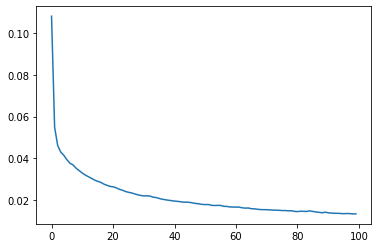

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [ ]:
Z = model.encoder(torch.tensor(X.astype(np.float32)).to(device))

In [ ]:
Z = Z.to('cpu').detach().numpy()

In [ ]:
# просто запуск DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import v_measure_score

clustering = DBSCAN().fit(Z)
print (np.unique(clustering.labels_))

print (f'V={v_measure_score(y, clustering.labels_)}')

[-1]
V=0.0


In [ ]:
import umap
reducer = umap.UMAP(n_neighbors=15, n_components=64, min_dist=0.1)
embedding = reducer.fit_transform(Z)

In [ ]:
clustering = DBSCAN().fit(embedding)
print (np.unique(clustering.labels_))

print (f'V={v_measure_score(y, clustering.labels_)}')

[-1  0  1  2  3  4  5  6  7  8  9 10]
V=0.050821089694211334


In [ ]:
# "умный перебор ??" НЕ РАБОТАЕТ!!!!

# %%
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics import make_scorer

def score_func(y_true, y_pred, **kwargs):
    return v_measure_score(y_true, y_pred)
scorer = make_scorer(score_func)


from sklearn.model_selection import GridSearchCV


base_opt = DBSCAN()
grid_search_params = {"min_samples":np.arange(10),
                        "eps":[0.001, 0.01, 0.05, 0.1, 0.2]}

grid_search_cv = GridSearchCV(estimator=base_opt,
                                param_grid=grid_search_params,
                                scoring=scorer)

grid_search_cv.fit(X, y)

GridSearchCV(estimator=DBSCAN(),
             param_grid={'eps': [0.001, 0.01, 0.05, 0.1, 0.2],
                         'min_samples': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring=make_scorer(score_func))

In [ ]:
grid_search_cv.cv_results_

{'mean_fit_time': array([0.8972559 , 0.94811902, 0.75881109, 0.61549244, 0.617523  ,
        0.61192832, 0.61926355, 0.61944776, 0.6121037 , 0.60665574,
        0.61789083, 0.63896122, 0.61545715, 0.62140393, 0.62202125,
        0.60895128, 0.61401548, 0.61523528, 0.71359167, 0.60869546,
        0.61945233, 0.63438616, 0.60807204, 0.60719352, 0.61616864,
        0.61635227, 0.61535869, 0.61093593, 0.60999212, 0.61265845,
        0.6197576 , 0.77686715, 0.60534415, 0.61044016, 0.60401821,
        0.60203066, 0.60233264, 0.60543265, 0.5943233 , 0.60627627,
        0.61365867, 0.61656098, 0.58812757, 0.59287815, 0.57725143,
        0.57703819, 0.58473983, 0.57458615, 0.76577506, 0.56030059]),
 'mean_score_time': array([0.00041504, 0.00031843, 0.00024424, 0.00021892, 0.00022063,
        0.00022883, 0.00025711, 0.00022702, 0.00028086, 0.00021005,
        0.00023599, 0.00026927, 0.00022335, 0.00026836, 0.0002388 ,
        0.00021949, 0.00021882, 0.00022535, 0.0002564 , 0.00022316,
        0.

In [ ]:
a = [(lambda: i for i in range(3))]
b = [f() for f in a]
print (b)

TypeError: ignored

In [ ]:
print(lambda: 1, lambda: 2, lambda: 3)

<function <lambda> at 0x7f4abb9d8a70> <function <lambda> at 0x7f4abb9d8b00> <function <lambda> at 0x7f4abb9d8b90>


In [ ]:
a = [(lambda: 1), (lambda: 2)]
a

[<function __main__.<lambda>()>, <function __main__.<lambda>()>]

In [ ]:
a = [(lambda: 1), (lambda: 2)]

In [ ]:
b = [f() for f in a]
print (b)

[1, 2]


In [ ]:
a = []
for i in range(3):
    def fun(): return i
    a.append(fun)
b = [f() for f in a]
print (b)

[2, 2, 2]


In [ ]:
[id(s) for s in a]

[139958952197152, 139958952195280, 139958952196720]

In [ ]:
print (id(lambda: 1) == id(lambda: 2))

True


In [ ]:
a = []
for i in range(3):
    def fun(): return i
    a.append(fun)
b = [f() for f in a]
print ([id(s) for s in b])

[11256096, 11256096, 11256096]


In [ ]:
a = []
for i in range(3):
    if i == 0:
        def foo(): return i
        a.append(foo)
    else:
        def bar(): return i
        a.append(bar)

In [ ]:
b = [f() for f in a]
print (b)

[2, 2, 2]


In [ ]:
id(lambda: 1) == id(lambda: 2)

True